<a href="https://colab.research.google.com/github/vigneshnani1234/AI-ML-RAG-Other/blob/main/Langgraph_DEMO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install langgraph langchain langsmith

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.7/143.7 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 10.8 MB/s eta 0:00:00


In [3]:
!pip install langchain_groq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.1/131.1 kB 3.4 MB/s eta 0:00:00


In [7]:
!pip install dotenv

In [17]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph,START,END,add_messages
from langchain_groq import ChatGroq
import os
from dotenv import load_dotenv

In [80]:
from google.colab import userdata
os.environ["GROQ_API_KEY"] = userdata.get("GROQ_API_KEY")
llm=ChatGroq(model='"llama3-8b-8192')

In [48]:

class State(TypedDict):
  messages=Annotated[list,add_messages]


In [44]:
def chatbot(state:State):

  messages = state.get("messages", [])
  return {"messages": llm.invoke(messages)}


In [45]:
graph_builder=StateGraph(State)
graph_builder.add_node("llm_chatbot",chatbot)
graph_builder.add_edge(START,"llm_chatbot")
graph_builder.add_edge("llm_chatbot",END)
graph=graph_builder.compile()

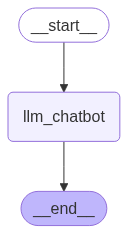

Chatbot graph visualized: START -> llm_chatbot -> END


In [46]:
from IPython.display import Image, display # [10]
try:
    display(Image(graph.get_graph().draw_mermaid_png())) # [10]
except Exception:
    pass # [10]
print("Chatbot graph visualized: START -> llm_chatbot -> END")

In [47]:
from langchain_core.messages import HumanMessage  # ✅ Import

user_message="Hi,How are you"
response = graph.invoke({"messages": [HumanMessage(content=user_message)]})  # ✅ Correct format
print(response)

{'messages': [HumanMessage(content='Hi,How are you', additional_kwargs={}, response_metadata={}, id='45a5fbcf-2375-4da9-9854-2cf795229ec3'), AIMessage(content="Hi! I'm just a language model, so I don't have feelings like humans do, but I'm functioning properly and ready to help with any questions or tasks you may have! How can I assist you today?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 45, 'prompt_tokens': 15, 'total_tokens': 60, 'completion_time': 0.030312102, 'prompt_time': 0.0021752, 'queue_time': 0.194479443, 'total_time': 0.032487302}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_24ec19897b', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--bafb3f8f-0b1a-4c46-b2be-083917d50b4b-0', usage_metadata={'input_tokens': 15, 'output_tokens': 45, 'total_tokens': 60})]}


In [49]:
!pip install langchain_tavily

In [55]:
from google.colab import userdata
os.environ['TAVILY_API_KEY']=userdata.get('TAVILY_KEY')
from langchain_tavily import TavilySearch
tool=TavilySearch(max_results=2)
tool.invoke("waht  is langchain")
# print(response)

{'query': 'waht  is langchain',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://python.langchain.com/docs/introduction/',
   'title': 'Introduction | 🦜️   LangChain',
   'content': "*   Build a simple LLM application with chat models and prompt templates *   How to migrate from legacy LangChain agents to LangGraph *   How to use chat models to call tools *   How to pass tool outputs to chat models *   **`langchain`**: Chains, agents, and retrieval strategies that make up an application's cognitive architecture. However, these guides will help you quickly accomplish common tasks using chat models, vector stores, and other common LangChain components. LangChain is part of a rich ecosystem of tools that integrate with our framework and build on top of it. If you're looking to get up and running quickly with chat models, vector stores, or other LangChain components from a specific provider, check out our growing list of integrations.",
   'score'

In [63]:
!pip install langchain_core

LLM using tools

In [118]:
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode,tools_condition
from langchain_core.tools import tool # Corrected import
from langchain_tavily import TavilySearch

In [120]:
tavily_tool=TavilySearch(max_results=2)

In [121]:
@tool
def multiply(a: int, b: int) -> int:
    """
    Multiply two numbers.

    Args:
        a: First number.
        b: Second number.
    """
    return a * b


In [122]:
tools=[tavily_tool,multiply]

In [123]:
llm_with_tools = llm.bind_tools(tools)


In [138]:
def tool_calling_llm(state:State):
  messages=state.get("messages",[])
    # ✅ Safety check
  if not messages or not all(isinstance(m, BaseMessage) for m in messages):
      raise ValueError("State 'messages' must be a non-empty list of BaseMessage objects.")

  ai_reply = llm_with_tools.invoke(messages)
  return {"messages": messages + [ai_reply]}

In [139]:
graph_builder=StateGraph(State)
graph_builder.add_node("tool_calling_llm", tool_calling_llm)
graph_builder.add_node("tools", ToolNode(tools)) # [16]
graph_builder.add_edge(START, "tool_calling_llm") # [16]


In [140]:
graph_builder.add_conditional_edges(
    "tool_calling_llm", # Source node [17]
    tools_condition,    # Condition to evaluate [17]
    {"tools": "tools", "end": END} # Mapping of condition output to target nodes [17]
)

In [141]:
graph = graph_builder.compile()

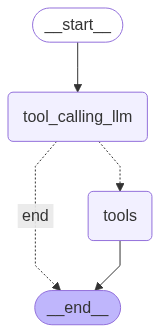

Chatbot graph with tools visualized: START -> tool_calling_llm (conditional) -> tools -> tool_calling_llm -> END


In [142]:
from IPython.display import Image, display # [20]
try:
    display(Image(graph.get_graph().draw_mermaid_png())) # [20]
except Exception:
    print("Graph visualization failed. Ensure 'graphviz' is installed.")
print("Chatbot graph with tools visualized: START -> tool_calling_llm (conditional) -> tools -> tool_calling_llm -> END")

In [166]:
from langchain_core.messages import HumanMessage

userquery1="give me the recent AI news"
resposne1=graph.invoke({"messages": [HumanMessage(content=userquery1)]})
print(resposne1)

ValueError: Checkpointer requires one or more of the following 'configurable' keys: thread_id, checkpoint_ns, checkpoint_id

In [167]:
!pip install -U langchain langgraph langchain-community langchain-core python-dotenv
!pip install -U tavily-python  # Required for Tavily tool


In [148]:
from langchain_community.tools.tavily_search import TavilySearchResults


In [153]:
# ✅ 1. Imports
import os
from typing import Annotated
from typing_extensions import TypedDict
from dotenv import load_dotenv

from langchain_core.messages import HumanMessage, AIMessage, BaseMessage
from langchain_core.tools import tool
from langchain_groq import ChatGroq
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

# ✅ 2. Load environment variables (set .env or use os.environ manually)
load_dotenv()
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")

# ✅ 3. Initialize LLM + Tools
llm = ChatGroq(model_name="llama3-8b-8192")
tavily_tool = TavilySearchResults(max_results=2)

@tool
def multiply(a: int, b: int) -> int:
    """Multiply two numbers.

    Args:
        a: First number.
        b: Second number.
    """
    return a * b

tools = [tavily_tool, multiply]
llm_with_tools = llm.bind_tools(tools)

# ✅ 4. Define Graph State
class State(TypedDict):
    messages: Annotated[list, add_messages]

# ✅ 5. Define LLM Node (calls tools if needed)
def tool_calling_llm(state: State):
    messages = state.get("messages", [])
    if not messages or not all(isinstance(m, BaseMessage) for m in messages):
        raise ValueError("State 'messages' must be a non-empty list of BaseMessage objects.")
    ai_reply = llm_with_tools.invoke(messages)
    return {"messages": messages + [ai_reply]}

# ✅ 6. Build the Graph
graph_builder = StateGraph(State)
graph_builder.add_node("tool_calling_llm", tool_calling_llm)
graph_builder.add_node("tools", ToolNode(tools))
graph_builder.add_edge(START, "tool_calling_llm")
graph_builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition,
    {"tools": "tools", "__end__": END}  # <-- ✅ fix
)
graph_builder.add_edge("tools", "tool_calling_llm")
graph = graph_builder.compile()

# ✅ 7. Run Examples
print("\n--- Chatbot with Tools Interaction ---")

# Example 1: Web search (Tavily)
query1 = "What are the recent AI news?"
response1 = graph.invoke({"messages": [HumanMessage(content=query1)]})
print(f"\nUser: {query1}")
print("AI:", response1["messages"][-1].content)

# Example 2: Math tool call
query2 = "What is 9 multiplied by 6?"
response2 = graph.invoke({"messages": [HumanMessage(content=query2)]})
print(f"\nUser: {query2}")
print("AI:", response2["messages"][-1].content)

# Example 3: Chain of reasoning (news + math)
query3 = "Tell me the latest AI news and then multiply 3 by 5"
response3 = graph.invoke({"messages": [HumanMessage(content=query3)]})
print(f"\nUser: {query3}")
print("AI:", response3["messages"][-1].content)

# Optional: Print full message trace
# for m in response3["messages"]:
#     m.pretty_print()



--- Chatbot with Tools Interaction ---

User: What are the recent AI news?
AI: Here's a summary of the recent AI news based on the output:

* Google has announced several AI updates in June, including AlphaGenome, a new AI model to help researchers better understand the human genome. This model is available in preview via the AlphaGenome API for non-commercial research.
* Google has also introduced new AI features in Chromebooks, such as improved search and photo recognition.
* In the field of generative AI, Meta has released Llama 4, which includes models like Scout and Maverick that are designed to handle politically and socially contentious questions more effectively than their predecessors.
* AI algorithms are being used to process vast datasets and provide insights that support strategic planning and resource allocation to streamline decision-making.
* AI and machine learning have had significant advancements across multiple sectors, including healthcare, finance, and education.


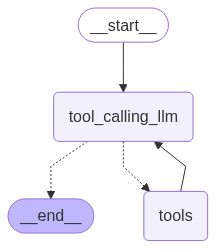

Chatbot graph with tools visualized: START -> tool_calling_llm (conditional) -> tools -> tool_calling_llm -> END


In [155]:
# ✅ 6. Build the Graph
graph_builder = StateGraph(State)
graph_builder.add_node("tool_calling_llm", tool_calling_llm)
graph_builder.add_node("tools", ToolNode(tools))
graph_builder.add_edge(START, "tool_calling_llm")
graph_builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition,
    {"tools": "tools", "__end__": END}  # <-- ✅ fix
)
graph_builder.add_edge("tools", "tool_calling_llm")
graph = graph_builder.compile()
from IPython.display import Image, display # [20]
try:
    display(Image(graph.get_graph().draw_mermaid_png())) # [20]
except Exception:
    print("Graph visualization failed. Ensure 'graphviz' is installed.")
print("Chatbot graph with tools visualized: START -> tool_calling_llm (conditional) -> tools -> tool_calling_llm -> END")

In [160]:
userquery="what is latest AInews and what is 3 multiplies by 7"
response=graph.invoke({"messages":[HumanMessage(content=userquery)]})
print(response)

{'messages': [HumanMessage(content='what is latest AInews and what is 3 multiplies by 7', additional_kwargs={}, response_metadata={}, id='b1671bd6-8779-4c6a-a496-5546270efdd5'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '5rc6vm6t2', 'function': {'arguments': '{"query":"latest AInews"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'yk94ea2mn', 'function': {'arguments': '{"a":3,"b":7}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 138, 'prompt_tokens': 1061, 'total_tokens': 1199, 'completion_time': 0.117707676, 'prompt_time': 0.227398504, 'queue_time': 0.6363474010000001, 'total_time': 0.34510618}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_24ec19897b', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--c01ce6ac-b02b-46fe-a0e2-488cbaaa0a2a-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'latest AInews'}, 'id': '5rc

Adding Memory in Agent

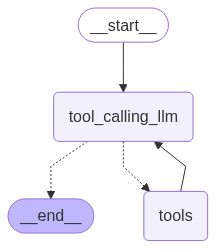

Chatbot graph with tools visualized: START -> tool_calling_llm (conditional) -> tools -> tool_calling_llm -> END


In [163]:
# ✅ 6. Build the Graph
from langgraph.checkpoint.memory import MemorySaver
memory=MemorySaver()
graph_builder = StateGraph(State)
graph_builder.add_node("tool_calling_llm", tool_calling_llm)
graph_builder.add_node("tools", ToolNode(tools))
graph_builder.add_edge(START, "tool_calling_llm")
graph_builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition,
    {"tools": "tools", "__end__": END}  # <-- ✅ fix
)
graph_builder.add_edge("tools", "tool_calling_llm")
graph = graph_builder.compile(checkpointer=memory)
from IPython.display import Image, display # [20]
try:
    display(Image(graph.get_graph().draw_mermaid_png())) # [20]
except Exception:
    print("Graph visualization failed. Ensure 'graphviz' is installed.")
print("Chatbot graph with tools visualized: START -> tool_calling_llm (conditional) -> tools -> tool_calling_llm -> END")

In [169]:
config={"configurable":{"thread_id":"1"}}
response=graph.invoke({"messages":"hi my name is vignesh"},config=config)
response['messages'][-1].content

'Nice to meet you again, Vignesh!'

In [170]:
response=graph.invoke({"messages":"waht do you think my name is?"},config=config)
response['messages'][-1].content

'I think your name is vignesh'